# HW03 Aitor Larrinoa

## Modelo VAR para BMW y Volkswagen

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Packages

In [2]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yahoofinancials as yf
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str

In [3]:
# Importamos la libreria de gráficos Seaborn
import seaborn as sns
sns.set(rc={'figure.figsize':(9, 4.5)})

In [4]:
from yahoofinancials import YahooFinancials

In [5]:
from statsmodels.tsa.stattools import adfuller

## Datos
Seleccionamos la base de datos macroeconomicos de Statsmodels

In [6]:
yf_BMW = YahooFinancials('BMW.DE')
data_BMW = yf_BMW.get_historical_price_data(
  start_date='2009-01-30',
  end_date='2020-11-01', 
  time_interval='daily'
) 
 
df_BMW = pd.DataFrame(data_BMW['BMW.DE']['prices'])
df_BMW['formatted_date'] = pd.to_datetime(df_BMW['formatted_date'])
df_BMW = df_BMW.set_index("formatted_date")
df_BMW = df_BMW[["adjclose"]]
df_BMW.head()

,adjclose
formatted_date,
2009-01-30,11.898610
2009-02-02,11.259245
2009-02-03,11.588517
2009-02-04,12.384529
2009-02-05,12.528385


In [7]:
yf_VOW = YahooFinancials('VOW.DE')
data_VOW = yf_VOW.get_historical_price_data(
  start_date='2009-01-30',
  end_date='2020-11-01', 
  time_interval='daily'
) 
 
df_VOW = pd.DataFrame(data_VOW['VOW.DE']['prices'])
df_VOW['formatted_date'] = pd.to_datetime(df_VOW['formatted_date'])
df_VOW = df_VOW.set_index("formatted_date")
df_VOW = df_VOW[["adjclose"]]
df_VOW.head()

,adjclose
formatted_date,
2009-01-30,192.005600
2009-02-02,195.731003
2009-02-03,198.586655
2009-02-04,203.751480
2009-02-05,200.126083


In [8]:
df_BMW_m = df_BMW.resample("m").last()
df_BMW_m

,adjclose
formatted_date,
2009-01-31,11.898610
2009-02-28,12.627487
2009-03-31,13.931794
2009-04-30,16.783369
2009-05-31,16.435894
...,...
2020-06-30,54.252777
2020-07-31,52.228565
2020-08-31,57.432327


In [9]:
df_VOW_m = df_VOW.resample("m").last()
df_VOW_m

,adjclose
formatted_date,
2009-01-31,192.005600
2009-02-28,144.706573
2009-03-31,178.035248
2009-04-30,185.695984
2009-05-31,165.715958
...,...
2020-06-30,136.308868
2020-07-31,126.226013
2020-08-31,142.872238


#### Realizamos un join de ambos data frames para tener todos los datos en un único data frame

In [10]:
df_data = df_BMW_m.merge(df_VOW_m, on="formatted_date", suffixes=["BMW", "VOW"])
df_data

,adjcloseBMW,adjcloseVOW
formatted_date,,
2009-01-31,11.898610,192.005600
2009-02-28,12.627487,144.706573
2009-03-31,13.931794,178.035248
2009-04-30,16.783369,185.695984
2009-05-31,16.435894,165.715958
...,...,...
2020-06-30,54.252777,136.308868
2020-07-31,52.228565,126.226013
2020-08-31,57.432327,142.872238


#### Cambiamos los nombres de las columnas para que sea más cómodo

In [11]:
df_data=df_data.rename(columns={'adjcloseBMW': 'Price_BMW', 'adjcloseVOW':'Price_VOW'})

### Gráficas de las series temporales

#### Graficamos ahora ambas series por separado y después las dos juntas

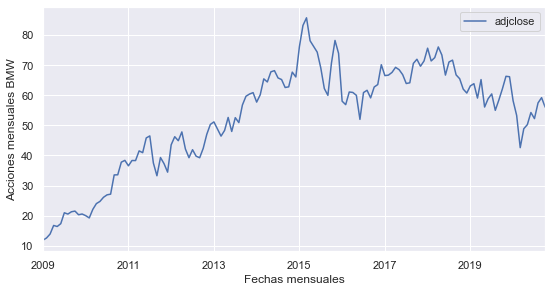

In [12]:
ax_1 = df_BMW_m.plot(linestyle = '-')
ax_1.set_ylabel("Acciones mensuales BMW") # Añadimos título al eje y 
ax_1.set_xlabel("Fechas mensuales"); # Añadimos título al eje x
# Guardamos la imagen para poder incluirla en el informe
plt.savefig("BMW time series.png", dpi=300, bbox_inches='tight')

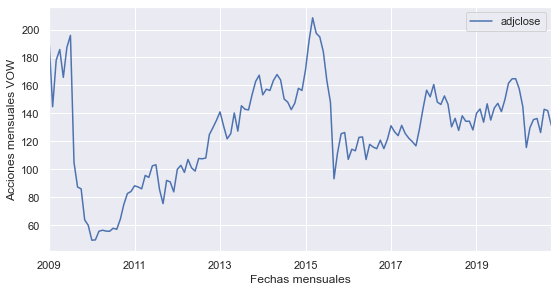

In [13]:
ax_2 = df_VOW_m.plot(linestyle = '-')
ax_2.set_ylabel("Acciones mensuales VOW") # Añadimos título al eje y 
ax_2.set_xlabel("Fechas mensuales"); # Añadimos título al eje x
# Guardamos la imagen para poder incluirla en el informe
plt.savefig("VOW time series.png", dpi=300, bbox_inches='tight')

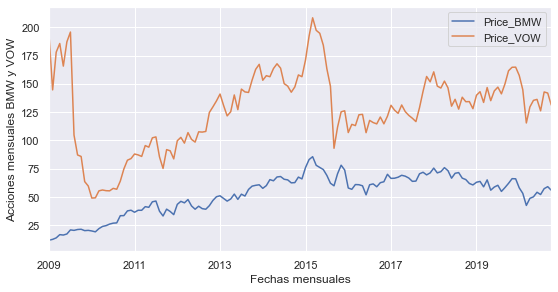

In [14]:
ax_3 = df_data.plot(linestyle = '-')
ax_3.set_ylabel("Acciones mensuales BMW y VOW") # Añadimos título al eje y 
ax_3.set_xlabel("Fechas mensuales"); # Añadimos título al eje x
# Guardamos la imagen para poder incluirla en el informe
plt.savefig("Both time series together.png", dpi=300, bbox_inches='tight')

#### Creamos ahora un nuevo data frame en el que escalaremos los valores de los precios entre 0 y 1 para poder ver ambas series a la misma escala

In [15]:
df_data_scaled = df_data[:]
df_data_scaled["Price_BMW"] = (df_data["Price_BMW"] - min(df_data["Price_BMW"])) / (max(df_data["Price_BMW"]) - min(df_data["Price_BMW"]))
df_data_scaled["Price_VOW"] = (df_data["Price_VOW"] - min(df_data["Price_VOW"])) / (max(df_data["Price_VOW"]) - min(df_data["Price_VOW"]))
df_data_scaled

,Price_BMW,Price_VOW
formatted_date,,
2009-01-31,0.000000,0.897011
2009-02-28,0.009879,0.600077
2009-03-31,0.027558,0.809308
2009-04-30,0.066208,0.857401
2009-05-31,0.061499,0.731970
...,...,...
2020-06-30,0.574072,0.547358
2020-07-31,0.546636,0.484060
2020-08-31,0.617168,0.588562


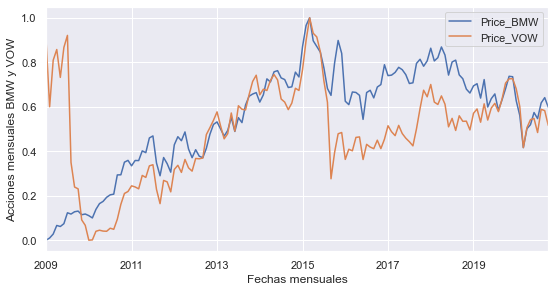

In [16]:
ax_4 = df_data_scaled.plot(linestyle = '-')
ax_4.set_ylabel("Acciones mensuales BMW y VOW") # Añadimos título al eje y 
ax_4.set_xlabel("Fechas mensuales"); # Añadimos título al eje x
# Guardamos la imagen para poder incluirla en el informe
plt.savefig("Both time series together (scaled).png", dpi=300, bbox_inches='tight')

## Test de Causalidad de Granger
Hasta 4 retardos

In [97]:
df_both = df_BMW_m.merge(df_VOW_m, on="formatted_date", suffixes=["BMW", "VOW"])
df_both

,adjcloseBMW,adjcloseVOW
formatted_date,,
2009-01-31,11.898610,192.005600
2009-02-28,12.627487,144.706573
2009-03-31,13.931794,178.035248
2009-04-30,16.783369,185.695984
2009-05-31,16.435894,165.715958
...,...,...
2020-06-30,54.252777,136.308868
2020-07-31,52.228565,126.226013
2020-08-31,57.432327,142.872238


In [99]:
gc_res = grangercausalitytests(df_both[['adjcloseVOW', 'adjcloseBMW']], maxlag=7)
# Volkswagen explica a BMW para los retardos 1,4,5,6,7


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1917  , p=0.0140  , df_denom=138, df_num=1
ssr based chi2 test:   chi2=6.3263  , p=0.0119  , df=1
likelihood ratio test: chi2=6.1885  , p=0.0129  , df=1
parameter F test:         F=6.1917  , p=0.0140  , df_denom=138, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7851  , p=0.1717  , df_denom=135, df_num=2
ssr based chi2 test:   chi2=3.7025  , p=0.1570  , df=2
likelihood ratio test: chi2=3.6544  , p=0.1609  , df=2
parameter F test:         F=1.7851  , p=0.1717  , df_denom=135, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3896  , p=0.0717  , df_denom=132, df_num=3
ssr based chi2 test:   chi2=7.5489  , p=0.0563  , df=3
likelihood ratio test: chi2=7.3510  , p=0.0615  , df=3
parameter F test:         F=2.3896  , p=0.0717  , df_denom=132, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.2034  , p=0.0152  

### Modelo VAR

#### Hacemos el test de Adfuller para ver si las series son estacionarias

In [100]:
for columna in df_both[['adjcloseVOW', 'adjcloseBMW']]:
    print("El p-valor de", columna, "es:")
    print(adfuller(df_both[columna])[1])

El p-valor de adjcloseVOW es:
0.04967705649496938
El p-valor de adjcloseBMW es:
0.13822297559427027


#### Concluimos que ninguna de las dos series es estacionaria pues se rechaza la hipótesis nula del test. Luego, tendremos que considerar la serie logarítimca

In [101]:
diff_df = np.log(df_both).diff().dropna()
diff_df

,adjcloseBMW,adjcloseVOW
formatted_date,,
2009-02-28,0.059454,-0.282816
2009-03-31,0.098298,0.207273
2009-04-30,0.186215,0.042129
2009-05-31,-0.020921,-0.113836
2009-06-30,0.055341,0.121788
...,...,...
2020-06-30,0.077172,0.006300
2020-07-31,-0.038025,-0.076849
2020-08-31,0.094978,0.123877


In [102]:
for columna in diff_df[['adjcloseVOW', 'adjcloseBMW']]:
    print("El p-valor de", columna, "es:")
    print(adfuller(diff_df[columna])[1])

El p-valor de adjcloseVOW es:
4.798552114000422e-22
El p-valor de adjcloseBMW es:
4.865227931741713e-16


#### Vemos ahora que la serie si es estacionaria.

In [103]:
model = VAR(diff_df)

/Users/aitor/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


#### Comprobamos el orden de VAR a elegir, atendiendo a su AIC

In [104]:
model.select_order(maxlags=15).summary()

,AIC,BIC,FPE,HQIC
0,-10.68,-10.64*,2.299e-05,-10.66*
1,-10.69*,-10.55,2.285e-05*,-10.63
2,-10.67,-10.44,2.332e-05,-10.57
3,-10.62,-10.30,2.452e-05,-10.49
4,-10.57,-10.17,2.557e-05,-10.41
5,-10.55,-10.05,2.632e-05,-10.35
6,-10.54,-9.954,2.651e-05,-10.30
7,-10.49,-9.813,2.793e-05,-10.21
8,-10.49,-9.726,2.786e-05,-10.18
9,-10.50,-9.647,2.760e-05,-10.15


In [105]:
# Lo estimamos sin constante, por eso le pongo tren="n"
results = model.fit(1, trend='n')
results.summary()
# Vemos también que hay correlación entre los residuos.

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 26, Nov, 2021
Time:                     13:35:37
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -9.83011
Nobs:                     140.000    HQIC:                  -9.88001
Log likelihood:           300.688    FPE:                4.94694e-05
AIC:                     -9.91416    Det(Omega_mle):     4.80857e-05
--------------------------------------------------------------------
Results for equation adjcloseBMW
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
L1.adjcloseBMW         0.090698         0.103883            0.873           0.383
L1.adjcloseVOW        -0.100251         0.077271           -1.297           0.194

Results for equation adjcloseVOW
                

#### Gráficos de los datos

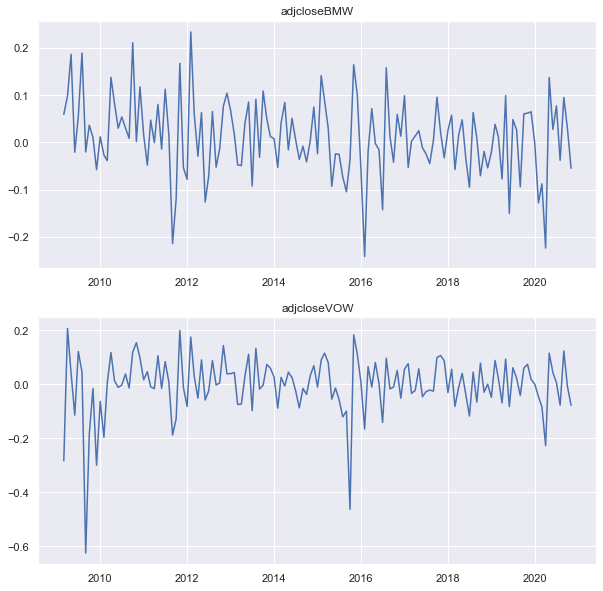

In [106]:
# se pone ; para que solo salga una vez.
results.plot();

#### Correlaciones de los residuos

¿Son ruido blanco?

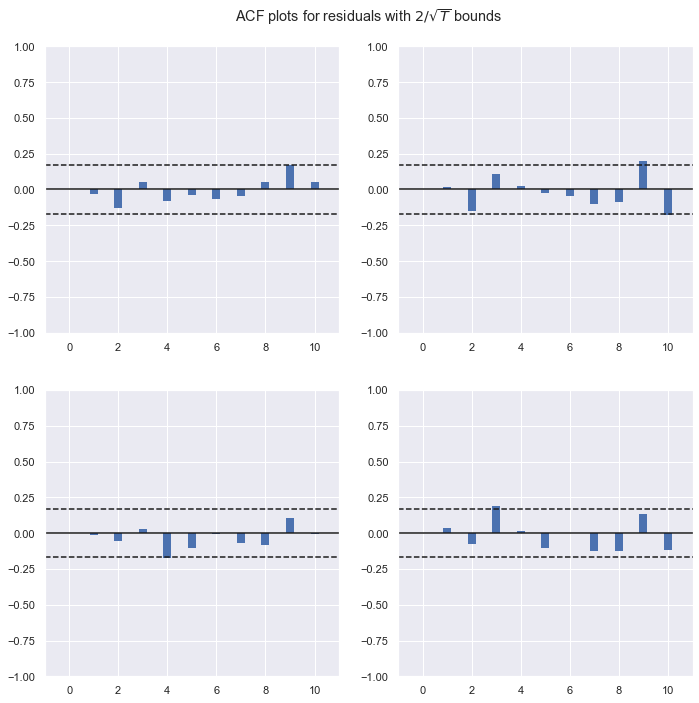

In [107]:
results.plot_acorr();
# nos fijamos en la primera columna

#### Predicción


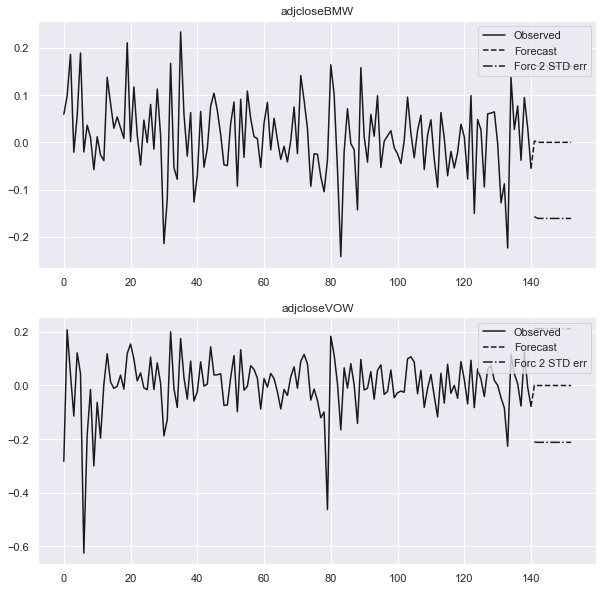

In [108]:
results.plot_forecast(12);
# las líneas de abajo son intervalos de confianza

In [28]:
data_BMW_2021 = yf_BMW.get_historical_price_data(
  start_date='2020-11-01',
  end_date='2021-11-01', 
  time_interval='daily'
) 
 
df_BMW_2021 = pd.DataFrame(data_BMW_2021['BMW.DE']['prices'])
df_BMW_2021['formatted_date'] = pd.to_datetime(df_BMW_2021['formatted_date'])
df_BMW_2021 = df_BMW_2021.set_index("formatted_date")
df_BMW_2021 = df_BMW_2021[["adjclose"]]
df_BMW_2021.head()

,adjclose
formatted_date,
2020-11-02,56.983559
2020-11-03,59.313316
2020-11-04,59.695244
2020-11-05,61.862682
2020-11-06,60.707355


In [29]:
data_VOW_2021 = yf_VOW.get_historical_price_data(
  start_date='2020-11-01',
  end_date='2021-11-01', 
  time_interval='daily'
) 
 
df_VOW_2021 = pd.DataFrame(data_VOW_2021['VOW.DE']['prices'])
df_VOW_2021['formatted_date'] = pd.to_datetime(df_VOW_2021['formatted_date'])
df_VOW_2021 = df_VOW_2021.set_index("formatted_date")
df_VOW_2021 = df_VOW_2021[["adjclose"]]
df_VOW_2021.head()

,adjclose
formatted_date,
2020-11-02,135.925751
2020-11-03,140.545059
2020-11-04,138.579391
2020-11-05,143.100433
2020-11-06,141.331329


In [89]:
df_BMW_2021_m = df_BMW_2021.resample("m").last()
df_BMW_2021_m

,adjclose
formatted_date,
2020-11-30,69.739929
2020-12-31,68.966537
2021-01-31,66.846832
2021-02-28,68.269516
2021-03-31,84.472778
2021-04-30,79.631851
2021-05-31,86.699997
2021-06-30,89.309998
2021-07-31,83.879997


In [90]:
df_VOW_2021_m = df_VOW_2021.resample("m").last()
df_VOW_2021_m

,adjclose
formatted_date,
2020-11-30,152.830475
2020-12-31,167.179840
2021-01-31,171.504288
2021-02-28,190.374680
2021-03-31,303.891846
2021-04-30,259.664398
2021-05-31,286.593994
2021-06-30,272.048065
2021-07-31,280.000000


In [91]:
df_data_2021 = df_BMW_2021_m.merge(df_VOW_2021_m, on="formatted_date", suffixes=["BMW", "VOW"])
df_data_2021

,adjcloseBMW,adjcloseVOW
formatted_date,,
2020-11-30,69.739929,152.830475
2020-12-31,68.966537,167.179840
2021-01-31,66.846832,171.504288
2021-02-28,68.269516,190.374680
2021-03-31,84.472778,303.891846
2021-04-30,79.631851,259.664398
2021-05-31,86.699997,286.593994
2021-06-30,89.309998,272.048065
2021-07-31,83.879997,280.000000


In [33]:
df_data_2021_diff = np.log(df_data_2021).diff().dropna()
df_data_2021_diff

,adjcloseBMW,adjcloseVOW
formatted_date,,
2020-12,-0.011152,0.089741
2021-01,-0.031218,0.025538
2021-02,0.021059,0.104386
2021-03,0.212966,0.467678
2021-04,-0.059015,-0.157282
2021-05,0.085040,0.098677
2021-06,0.029660,-0.052088
2021-07,-0.062726,0.028811
2021-08,-0.042746,0.011364


In [34]:
lag_order = results.k_ar
results.forecast(diff_df.values[-lag_order:], 11)

array([[ 2.81627178e-03,  9.59803129e-04],
       [ 1.59207843e-04, -1.61992412e-04],
       [ 3.06797668e-05, -1.72038622e-05],
       [ 4.50729784e-06, -2.79385747e-06],
       [ 6.88890018e-07, -4.20368484e-07],
       [ 1.04623322e-07, -6.40015081e-08],
       [ 1.59053435e-08, -9.72597968e-09],
       [ 2.41762238e-09, -1.47844763e-09],
       [ 3.67489420e-10, -2.24728426e-10],
       [ 5.58598127e-11, -3.41596435e-11],
       [ 8.49091291e-12, -5.19239989e-12]])

In [35]:
indice=df_data_2021_diff.index
indice

PeriodIndex(['2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05',
             '2021-06', '2021-07', '2021-08', '2021-09', '2021-10'],
            dtype='period[M]', name='formatted_date')

In [93]:
df_forecast = pd.DataFrame(data=results.forecast(diff_df.values[-lag_order:], 11), index=indice)
df_forecast

,0,1
formatted_date,,
2020-12,2.816272e-03,9.598031e-04
2021-01,1.592078e-04,-1.619924e-04
2021-02,3.067977e-05,-1.720386e-05
2021-03,4.507298e-06,-2.793857e-06
2021-04,6.888900e-07,-4.203685e-07
2021-05,1.046233e-07,-6.400151e-08
2021-06,1.590534e-08,-9.725980e-09
2021-07,2.417622e-09,-1.478448e-09
2021-08,3.674894e-10,-2.247284e-10


In [37]:
df_total = df_data_2021_diff.merge(df_forecast, left_index=True, right_index=True)
df_total

,adjcloseBMW,adjcloseVOW,0,1
formatted_date,,,,
2020-12,-0.011152,0.089741,2.816272e-03,9.598031e-04
2021-01,-0.031218,0.025538,1.592078e-04,-1.619924e-04
2021-02,0.021059,0.104386,3.067977e-05,-1.720386e-05
2021-03,0.212966,0.467678,4.507298e-06,-2.793857e-06
2021-04,-0.059015,-0.157282,6.888900e-07,-4.203685e-07
2021-05,0.085040,0.098677,1.046233e-07,-6.400151e-08
2021-06,0.029660,-0.052088,1.590534e-08,-9.725980e-09
2021-07,-0.062726,0.028811,2.417622e-09,-1.478448e-09
2021-08,-0.042746,0.011364,3.674894e-10,-2.247284e-10


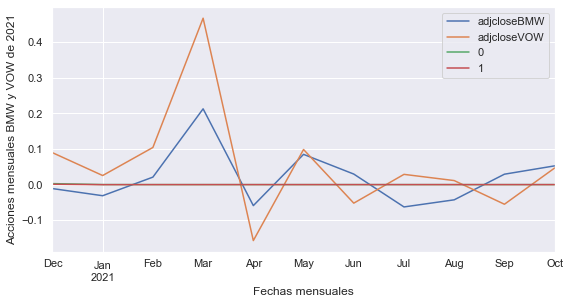

In [38]:
ax_4 = df_total.plot(linestyle = '-')
ax_4.set_ylabel("Acciones mensuales BMW y VOW de 2021") # Añadimos título al eje y 
ax_4.set_xlabel("Fechas mensuales"); # Añadimos título al eje x
# Guardamos la imagen para poder incluirla en el informe
plt.savefig("2021 lag diff.png", dpi=300, bbox_inches='tight')

## Función de Respuesta al Impulso

In [39]:
irf = results.irf(12)

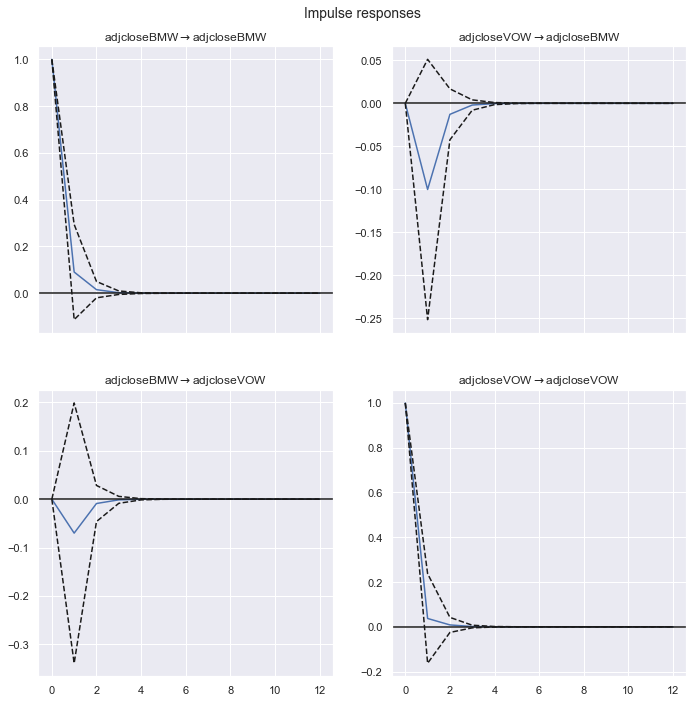

In [40]:
irf.plot(orth=False); # para que no tenga en cuenta la ortogonalidad en los residuos
# si el 0 entra dentro del intervalo de confianza, entonces el aumento es estadísticamente 0. 
# por ej el aumento de la inversón no tiene relevancia en el aumento del consumo porque el 0 está dentro del 
# intervalo de confianza

## Función de Respuesta al Impulso(Individual)

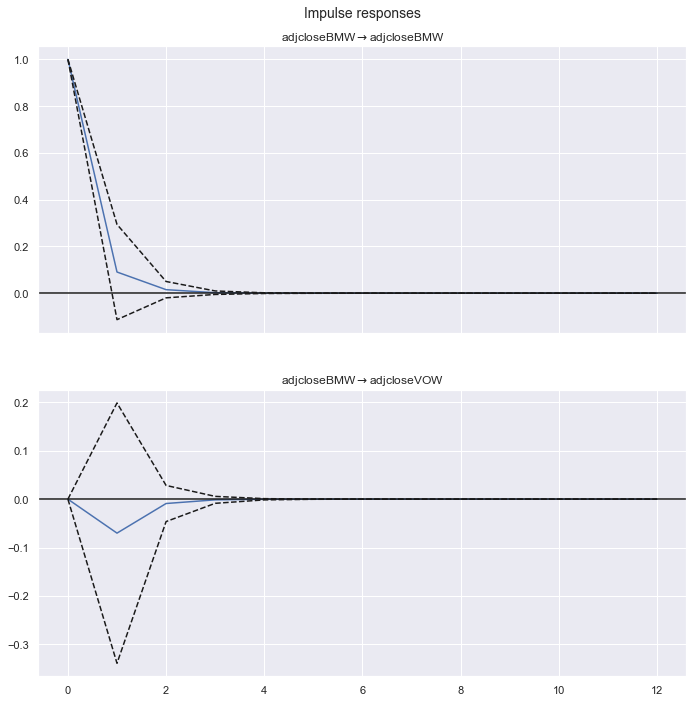

In [41]:
irf.plot(impulse='adjcloseBMW'); # Solo cojo una columna (solo el consumo)
# si aumento el consumo hoy, voy a ver un aumento de 0.7 en el gdp

## Función de Respuesta al Impulso ACUMULADA

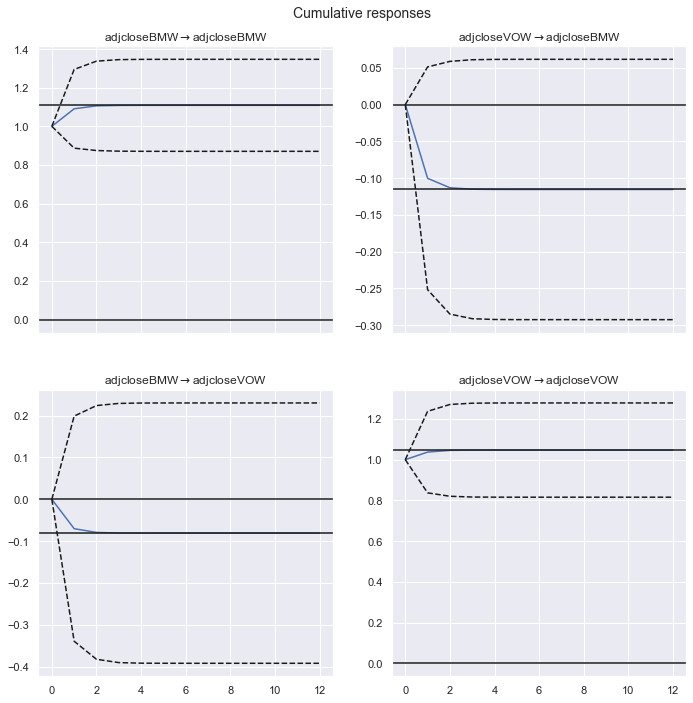

In [42]:
irf.plot_cum_effects(orth=False);
# la línea negra es la línea asintótica
# impulso en el consumo, me genera un aumento acumulado!!! en el gdp. Este muestra el aumento acumulado.
# la línea azul es el efecto puntual. Las líneas discontinuas son los intervalos de confianza


## Descomposiciñon del error de predicción

In [43]:
fevd = results.fevd(12)

In [44]:
fevd.summary()

FEVD for adjcloseBMW
      adjcloseBMW  adjcloseVOW
0        1.000000     0.000000
1        0.989291     0.010709
2        0.989118     0.010882
3        0.989114     0.010886
4        0.989113     0.010887
5        0.989113     0.010887
6        0.989113     0.010887
7        0.989113     0.010887
8        0.989113     0.010887
9        0.989113     0.010887
10       0.989113     0.010887
11       0.989113     0.010887

FEVD for adjcloseVOW
      adjcloseBMW  adjcloseVOW
0        0.383484     0.616516
1        0.383714     0.616286
2        0.383698     0.616302
3        0.383698     0.616302
4        0.383698     0.616302
5        0.383698     0.616302
6        0.383698     0.616302
7        0.383698     0.616302
8        0.383698     0.616302
9        0.383698     0.616302
10       0.383698     0.616302
11       0.383698     0.616302




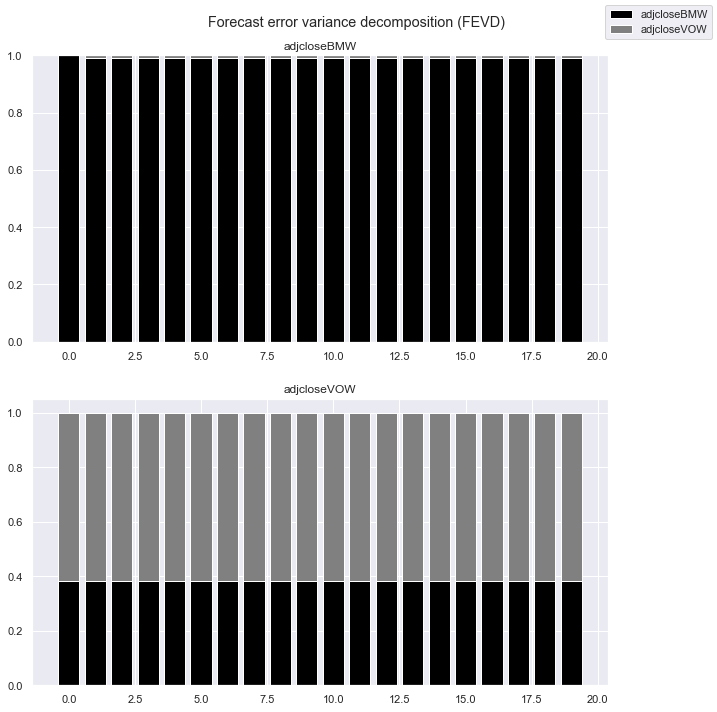

In [45]:
results.fevd(20).plot();
# gráfico porcentual en cada instante del tiempo.
# lo que se mira aquí es el porcentaje de la varianza

In [46]:
results.test_causality('adjcloseBMW', ['adjcloseVOW'], kind='f').summary()

Test statistic,Critical value,p-value,df
1.683,3.875,0.196,"(1, 276)"


In [47]:
results.test_causality('adjcloseVOW', ['adjcloseBMW'], kind='f').summary()

Test statistic,Critical value,p-value,df
0.2614,3.875,0.610,"(1, 276)"


## Modelo GARCH

In [48]:
# Read Data
yf_BMW = YahooFinancials('BMW.DE')
data_BMW = yf_BMW.get_historical_price_data(
  start_date="1996-01-01",
  end_date='2020-10-31', 
  time_interval='daily'
) 
 
df_BMW = pd.DataFrame(data_BMW['BMW.DE']['prices'])
df_BMW

,date,high,low,open,close,volume,adjclose,formatted_date
0,847440000,18.209999,18.171000,18.209999,18.171000,767000,10.041774,1996-11-08
1,847699200,18.200001,18.082001,18.190001,18.122000,260000,10.014692,1996-11-11
2,847785600,18.327999,18.091999,18.160999,18.259001,1066000,10.090403,1996-11-12
3,847872000,18.344000,18.190001,18.344000,18.230000,793000,10.074377,1996-11-13
4,847958400,18.289000,18.132000,18.205000,18.289000,351000,10.106981,1996-11-14
...,...,...,...,...,...,...,...,...
6145,1603699200,64.120003,62.779999,62.860001,63.209999,1118941,60.354069,2020-10-26
6146,1603785600,63.290001,61.340000,63.230000,61.470001,1839591,58.692688,2020-10-27
6147,1603872000,59.959999,57.250000,59.730000,58.060001,3729376,55.436756,2020-10-28
6148,1603958400,58.959999,57.580002,57.860001,58.330002,1788596,55.694557,2020-10-29


In [49]:
data=df_BMW[['formatted_date', 'adjclose']].rename(columns={'adjclose': 'Price', 'formatted_date':'Date'})
data['Date']=pd.to_datetime(data['Date'])
data=data.set_index('Date')
data

,Price
Date,
1996-11-08,10.041774
1996-11-11,10.014692
1996-11-12,10.090403
1996-11-13,10.074377
1996-11-14,10.106981
...,...
2020-10-26,60.354069
2020-10-27,58.692688
2020-10-28,55.436756


In [50]:
price_bmw2 = data.iloc[-1, 0]
price_bmw2

56.02873992919922

In [51]:
# Seaborn plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})

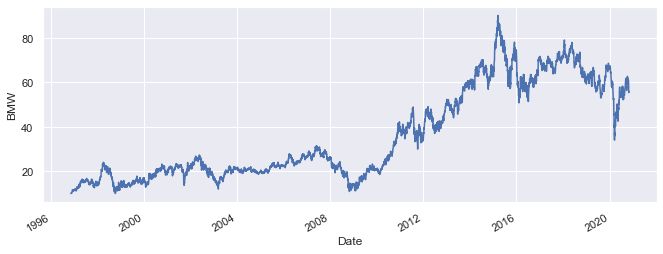

In [52]:
# Plot stock prices
ax = data.Price.plot( linestyle='-')
ax.set_ylabel('BMW');


 <div class="hr1"></div>
 # Calculate Daily Logarithmic Return and Squared
 <div class="hr1"></div>

In [53]:
# Log return
# rentabilidad logarítmica
# siempre que se usen tasas de variación para predecir, se usan tasas de variación logarítmicas
# 
data['log_ret'] =np.log(data.Price).diff()
data.tail()

,Price,log_ret
Date,,
2020-10-26,60.354069,-0.011326
2020-10-27,58.692688,-0.027913
2020-10-28,55.436756,-0.057072
2020-10-29,55.694557,0.004640
2020-10-30,56.028740,0.005982


In [54]:
# Squared Log return
# Proxy Volatility

data['Squared'] = data['log_ret']**2
data.tail()

,Price,log_ret,Squared
Date,,,
2020-10-26,60.354069,-0.011326,0.000128
2020-10-27,58.692688,-0.027913,0.000779
2020-10-28,55.436756,-0.057072,0.003257
2020-10-29,55.694557,0.004640,0.000022
2020-10-30,56.028740,0.005982,0.000036



 <div class="hr1"></div>
 #Plot return squared
 <div class="hr1"></div>

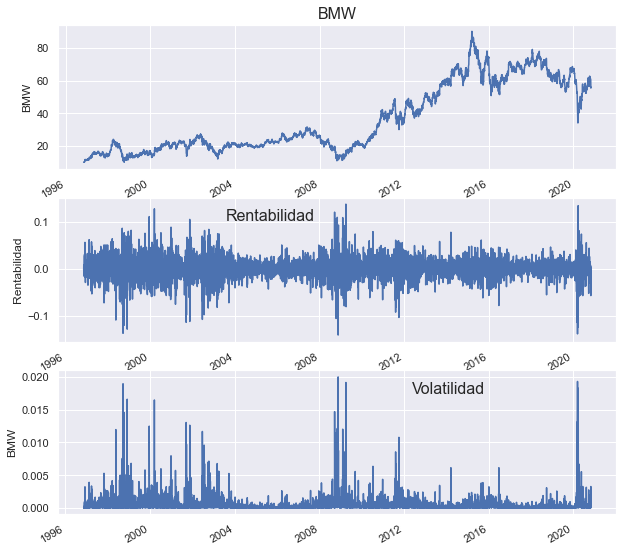

In [55]:
fig = plt.figure(figsize=(10,10))
plt.subplot(311)
ax=data.Price.plot( linestyle='-')
ax.set_ylabel('BMW')
ax.set_xlabel('')
ax.set_title('BMW', y=1, fontsize = 16)
plt.subplot(312)
ax=data.log_ret.plot( linestyle='-')
ax.set_ylabel('Rentabilidad')
ax.set_xlabel('')
ax.set_title('Rentabilidad', y=0.8, x=0.38, fontsize = 16)
plt.subplot(313)
ax=data.Squared.plot( linestyle='-')
ax.set_ylabel('BMW')
ax.set_xlabel('')
ax.set_title('Volatilidad', y=0.8, x=0.7, fontsize = 16)
plt.savefig("Rend, vol, and prices of BMW.png", dpi=300, bbox_inches='tight')



### Testing mean

In [56]:
# mean zero test
# voy a ver si la media es 0 con el ttest
from scipy import stats
alpha=0.05
t, p = stats.ttest_1samp(data['log_ret'].dropna(),0.0)
print ('Estadítico t:',t)
print ('p-value:',p)

if  p < alpha:
    print (f'Con {alpha} de significación: Rechazamos la hipotesis de media cero.')
else:
    print (f'Con {alpha} de significación: No podemos rechazar la hipotesis de media cero.')

Estadítico t: 1.0061952075836353
p-value: 0.3143612761320591
Con 0.05 de significación: No podemos rechazar la hipotesis de media cero.



 <div class="hr1"></div>
 ## ACF y PACF
 ## Ljung-Box Test
 <div class="hr1"></div>

In [57]:
# Autocorrelation Fuction Original Time Series
from sktime.utils.plotting import plot_correlations

In [58]:
# Create proxy Volatility 
bmw_vol=data['Squared'].astype('float64').to_period('D').sort_index().dropna()
bmw_vol.tail()

Date
2020-10-26    0.000128
2020-10-27    0.000779
2020-10-28    0.003257
2020-10-29    0.000022
2020-10-30    0.000036
Freq: D, Name: Squared, dtype: float64

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:ylabel='Squared'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

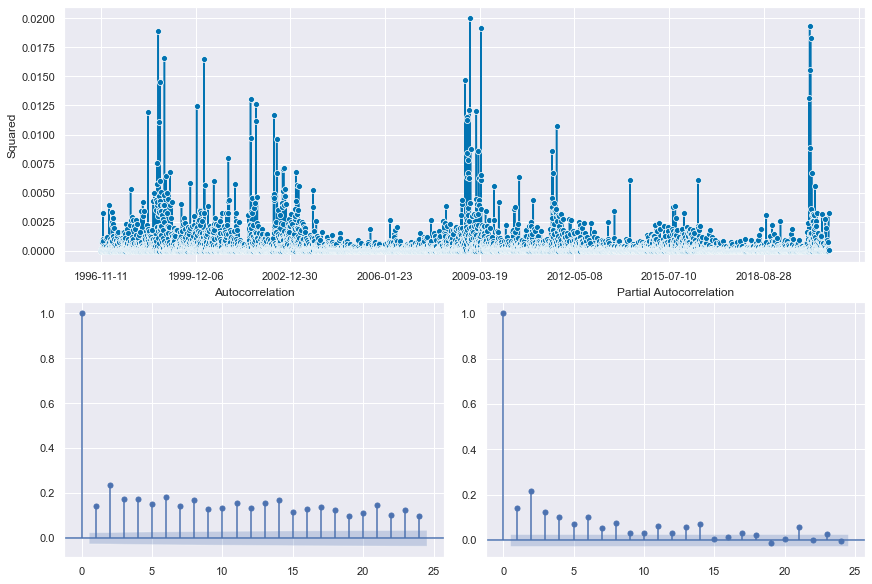

In [59]:
# Plot Autocorrelation
plot_correlations(bmw_vol)
# como tenemos un problema de autocorrelación, tenemos un problema de GARCH

In [60]:
# import function test Ljung_Box
import statsmodels.api as sm
test_Ljung_Box = sm.stats.acorr_ljungbox

In [61]:
#
# testing Ljung- para confirmar si hay problema GARCH o no
# pvalue < alpha -> No Ruido Blanco
test_Ljung_Box(bmw_vol, lags=[10,20,30], return_df=True)

,lb_stat,lb_pvalue
10,1672.970591,0.0
20,2759.138954,0.0
30,3516.357187,0.0



 <div class="hr1"></div>
 ## LM test
 <div class="hr1"></div>

In [62]:
# import function test LM-Arch
import statsmodels.api as sm
test_LM_ARCH=sm.stats.diagnostic.het_arch

In [63]:
#
# testing LM-ARCH
# pvalue < alpha -> ARCH
lm, lmpval, f, pval, result_int =test_LM_ARCH(data['log_ret'].dropna(), nlags=20, store=True)
print ('Estadístico LM: ', lm)
print ('p-value: ', lmpval)
print ('Estadístico F: ', f)
print ('p-value: ', pval)

Estadístico LM:  774.9850170931135
p-value:  2.8769174992754052e-151
Estadístico F:  44.20615649673333
p-value:  2.7291904508165087e-162


In [64]:
# esto no es necesario
result_int.resols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     44.21
Date:                Fri, 26 Nov 2021   Prob (F-statistic):          2.73e-162
Time:                        13:03:25   Log-Likelihood:                 32839.
No. Observations:                6129   AIC:                        -6.564e+04
Df Residuals:                    6108   BIC:                        -6.550e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   1.93e-05      6.648      0.000    9.06e-05       0.000
x1             0.0335      0.013      2.621      0.009       0.008       0.059
x2             0.1407      0.013     10.988      0.000       0.116       0.166
x3             0.0655      0.013      5.061      0.000       0.040       0.091
x4             0.0556      0.013      4.299      0.000       0.030       0.081
x5             0.0320      0.013      2.472      0.013       0.007       0.057
x6             0.0654      0.013      5.044      0.000       0.040       0.091
x7             0.0277      0.013      2.135      0.033       0.002       0.053
x8             0.0552      0.013      4.259      0.000       0.030       0.081
x9             0.0097      0.013      0.751      0.453      -0.016       0.035
x10            0.0123      0.013      0.946      0.344      -0.013       0.038
x11            0.0444      0.013      3.422      0.001       0.019       0.070
x12            0.0170      0.013      1.312      0.190      -0.008       0.042
x13            0.0506      0.013      3.901      0.000       0.025       0.076
x14            0.0640      0.013      4.934      0.000       0.039       0.089
x15            0.0002      0.013      0.012      0.991      -0.025       0.026
x16            0.0095      0.013      0.729      0.466      -0.016       0.035
x17            0.0337      0.013      2.605      0.009       0.008       0.059
x18            0.0209      0.013      1.618      0.106      -0.004       0.046
x19           -0.0140      0.013     -1.092      0.275      -0.039       0.011
x20            0.0057      0.013      0.444      0.657      -0.019       0.031
==============================================================================
Omnibus:                     7970.905   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1798525.835
Skew:                           7.205   Prob(JB):                         0.00
Kurtosis:                      85.674   Cond. No.                         998.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
from arch.univariate import ARX
from arch.univariate import ARCH, GARCH

# <div class="hr1"></div>
 ## GARCH(1,1)
 <div class="hr1"></div>

In [66]:
# estimamos un GARCH(1,1)
ar = ARX(100*data['log_ret'].dropna(), lags=[15])
print(ar.fit().summary())

                     AR - Constant Variance Model Results                     
Dep. Variable:                log_ret   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:          Constant Variance   Log-Likelihood:               -13484.1
Distribution:                  Normal   AIC:                           26974.3
Method:            Maximum Likelihood   BIC:                           26994.4
                                        No. Observations:                 6134
Date:                Fri, Nov 26 2021   Df Residuals:                     6132
Time:                        13:03:25   Df Model:                            2
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const           0.0273  2.788e-02      0.978      0.

In [67]:
# MODELO 
# GARCH(1,1)
ar.volatility = GARCH(p=1,q=1)
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                log_ret   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12583.2
Distribution:                  Normal   AIC:                           25176.4
Method:            Maximum Likelihood   BIC:                           25210.0
                                        No. Observations:                 6134
Date:                Fri, Nov 26 2021   Df Residuals:                     6132
Time:                        13:03:25   Df Model:                            2
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const           0.0541  2.126e-02      2.546  1.090e

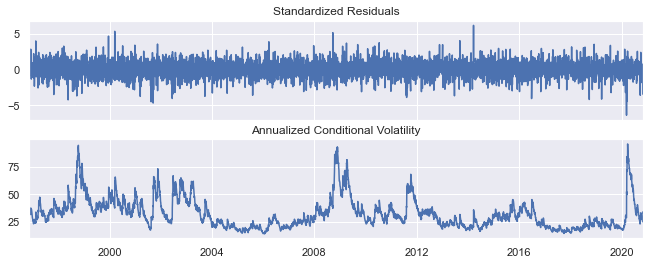

In [68]:
#
fig = res.plot(annualize="D")

In [69]:
# Análisis Residuos
mod1_std_resid=(res.resid / res.conditional_volatility).astype('float64').sort_index().dropna()

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

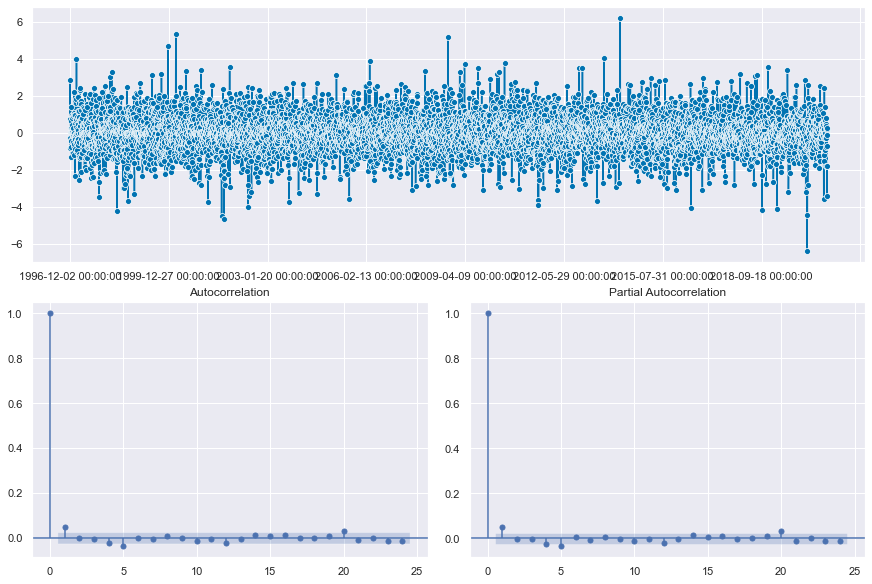

In [70]:
# Plot Autocorrelation
plot_correlations(mod1_std_resid)

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

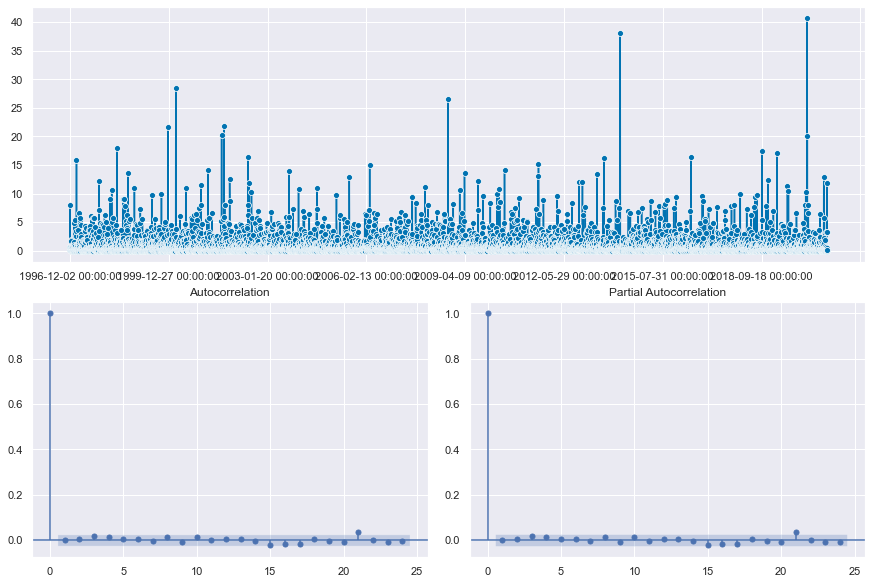

In [71]:
# Plot Autocorrelation
plot_correlations(mod1_std_resid**2)
# veamos si la z^2 es ruido blanco. Ahora vemos que no es problema GARCH y, la z cumple lo que queríamos

In [72]:
#
# testing Ljung-Box
# pvalue < alpha -> No Ruido Blanco
test_Ljung_Box(mod1_std_resid**2, lags=[10,20,30], return_df=True)

,lb_stat,lb_pvalue
10,6.377405,0.782622
20,15.188496,0.765522
30,26.501182,0.649324


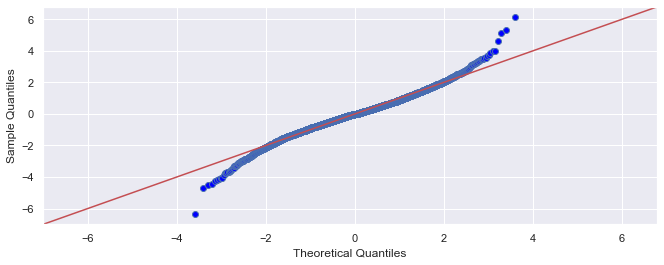

In [73]:
# qqplot
sm.qqplot(mod1_std_resid,line='45')
plt.show()
# el qqplot sigue sin ser normal.

In [74]:
# el modelo es correcto, pero no es correcta la distribución. Cambiamos de distribución

In [75]:
from arch.univariate import StudentsT

In [76]:
#
ar.distribution = StudentsT()
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                              AR - GARCH Model Results                              
Dep. Variable:                      log_ret   R-squared:                       0.000
Mean Model:                              AR   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -12434.3
Distribution:      Standardized Student's t   AIC:                           24880.5
Method:                  Maximum Likelihood   BIC:                           24920.9
                                              No. Observations:                 6134
Date:                      Fri, Nov 26 2021   Df Residuals:                     6132
Time:                              13:03:28   Df Model:                            2
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

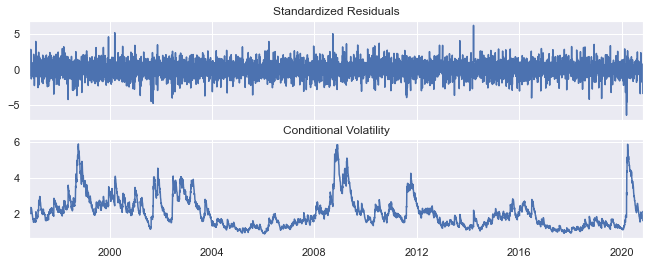

In [77]:
#
fig = res.plot()

In [78]:
# Análisis Residuos
mod1_std_resid=(res.resid / res.conditional_volatility).astype('float64').sort_index().dropna()

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

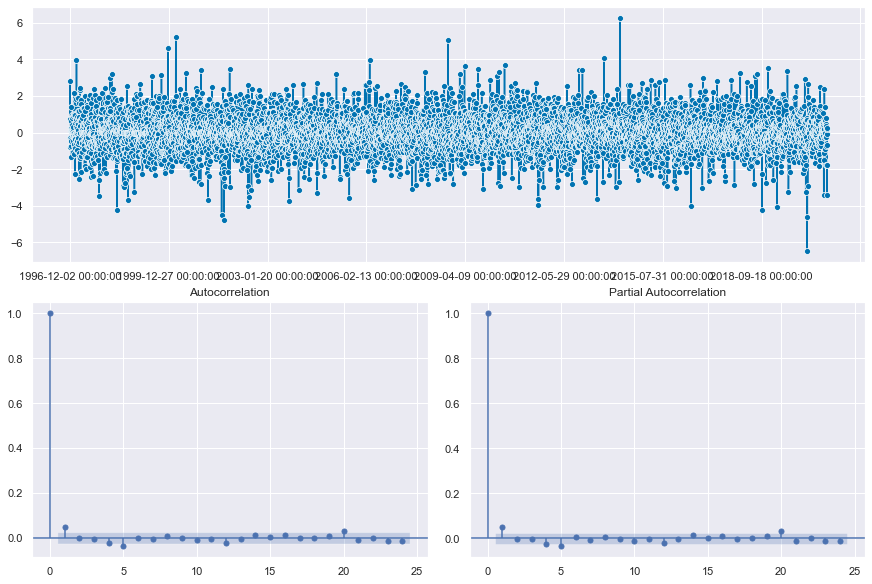

In [79]:
# Plot Autocorrelation
plot_correlations(mod1_std_resid)

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

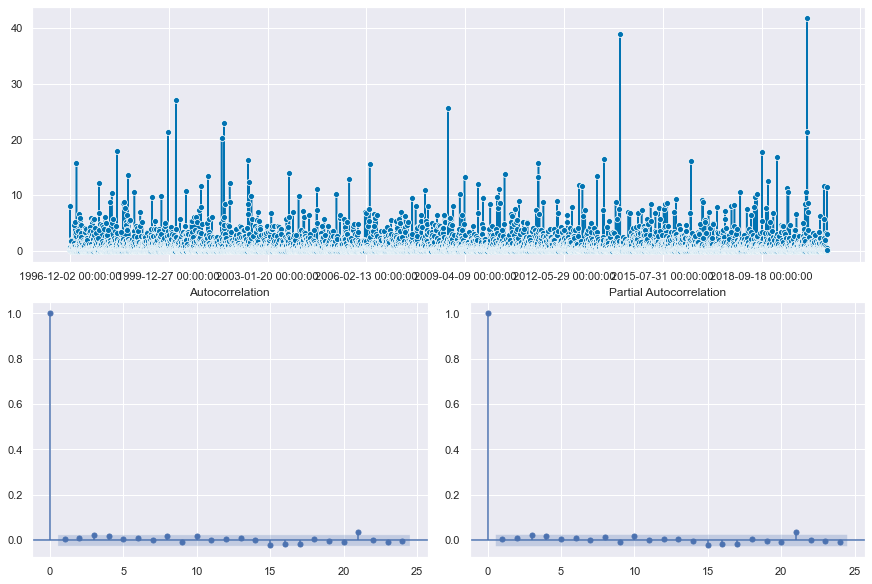

In [117]:
# Plot Autocorrelation
plot_correlations(mod1_std_resid**2)

#### Calculamos los p-valores del test de Ljung-Box

In [116]:
test_Ljung_Box(mod1_std_resid**2, lags=[10,20,30], return_df=True)

,lb_stat,lb_pvalue
10,10.240551,0.419649
20,18.455358,0.557439
30,30.348754,0.447900


#### Veamos cómo se ajustan los datos a una distribución t de student

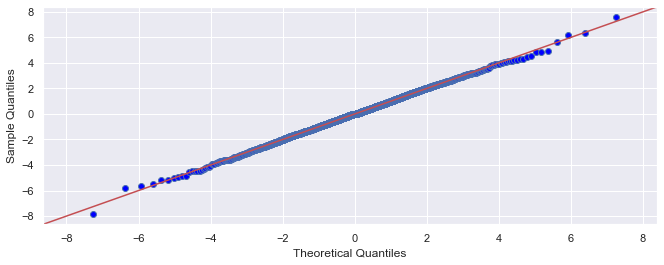

In [115]:
# qqplot t-student
sm.qqplot(mod1_std_resid,dist=stats.t,fit=True,line='45')
plt.show()
# casi casi lo hemos conseguido.

#### Vemos que el ajuste a la t de student es bastante mejor

# <div class="hr1"></div>
 ## Forecast Volatility
 <div class="hr1"></div>

In [83]:
# Predicción 30 días para mostrar las predicciones de noviembre
forecasts = res.forecast(horizon=30, reindex=False)

In [84]:
# predicciones para la media
predictions_GARCH = forecasts.mean
predictions_GARCH
# se hace constante porque revierte a la media

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.21,h.22,h.23,h.24,h.25,h.26,h.27,h.28,h.29,h.30
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-30,0.026636,0.059968,0.041828,0.090268,0.010574,0.023337,0.024814,0.044314,0.03169,0.039374,...,0.036771,0.036745,0.036402,0.036624,0.036489,0.036179,0.035668,0.034771,0.03667,0.036712


In [85]:
# predicción para la varianza
# varianza^(1/2). Para obtener la diaría, necesito multiplicar por la raiz e 252.
(forecasts.variance**0.5)*np.sqrt(252)
# cuanto mas dias pasen, más riesgo, luego más volatilidad.

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.21,h.22,h.23,h.24,h.25,h.26,h.27,h.28,h.29,h.30
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-30,31.912812,31.952874,31.992811,32.032624,32.072312,32.111878,32.15132,32.190641,32.22984,32.268918,...,32.695813,32.73349,32.771054,32.808504,32.845841,32.883066,32.92018,32.957182,32.994074,33.030855


In [86]:
# predicción de los precios
bmw_GARCH_prices = (np.exp(np.cumsum(predictions_GARCH))*price_bmw2)
bmw_GARCH_prices

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.21,h.22,h.23,h.24,h.25,h.26,h.27,h.28,h.29,h.30
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-30,57.541197,59.491477,58.422021,61.321642,56.624334,57.351679,57.436436,58.567429,57.832705,58.278821,...,58.127291,58.125785,58.105903,58.118774,58.110939,58.09292,58.063269,58.01118,58.121476,58.123878


In [87]:
list(bmw_GARCH_prices.iloc[0,:])

[57.5411968907998,
 59.491476637022224,
 58.42202119119547,
 61.321642073099476,
 56.62433403572712,
 57.35167911362416,
 57.43643588728623,
 58.56742873198297,
 57.832704647796554,
 58.278821395493196,
 59.318165670874,
 61.069712478998966,
 64.27515547969845,
 57.67968087669485,
 57.54396121988311,
 58.12392670478344,
 58.08994696600434,
 58.108437235804594,
 58.05907551040051,
 58.14030832792107,
 58.12729094375595,
 58.12578498144154,
 58.10590308616797,
 58.11877392915701,
 58.1109391893724,
 58.09292033516941,
 58.06326901317459,
 58.01118014946374,
 58.121475517756785,
 58.123877717059315]

#### Graficamos las predicciones

<AxesSubplot:>

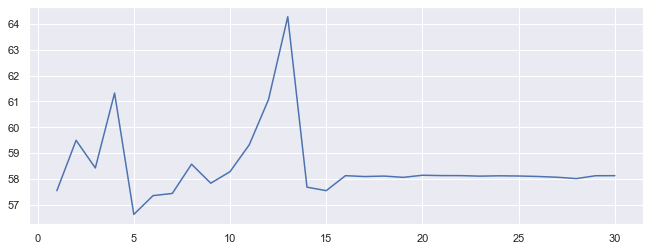

In [112]:
sns.lineplot(x=range(1,31), y=list(bmw_GARCH_prices.iloc[0,:]))

In [114]:
data.loc["2020-10"]

,Price,log_ret,Squared
Date,,,
2020-10-01,59.828918,0.010750,1.155670e-04
2020-10-02,59.542477,-0.004799,2.303212e-05
2020-10-05,61.137016,0.026428,6.984161e-04
2020-10-06,61.919971,0.012725,1.619321e-04
2020-10-07,62.769756,0.013631,1.857933e-04
2020-10-08,62.750664,-0.000304,9.254640e-08
2020-10-09,61.776745,-0.015642,2.446771e-04
2020-10-12,62.149124,0.006010,3.611684e-05
2020-10-13,61.347080,-0.012989,1.687179e-04
